## Calculate NBR and dNBR

### Burn Severity Analysis Methodology

#### Overview

This document contains a workflow to calculate NBR (Normalized Burn Ratio) and dNBR (difference NBR), metrics used as proxies for burn severity. In order to investigate longer-term damage, we include **1, 2, and 5 years post-fire** analyses.

#### Comparison to MTBS

The analyses were then compared to [MTBS (Monitoring Trends in Burn Severity)](https://www.mtbs.gov/direct-download). 

**Why we repeated these analyses:** MTBS doesn't use standard dNBR cutoffs, so fires aren't directly comparable to one another. Instead, we used standardized thresholds established in **Key & Benson (2006)**.

#### Burn Severity Classification

We applied the following **Key & Benson (2006) thresholds**:

| Severity Class | dNBR Range | Pixels | Percentage |
|:---------------|:-----------|:-------|:-----------|
| **High Severity** | >0.66 | 2,509 | 4.4% |
| **Moderate-High** | 0.44-0.66 | 10,862 | 18.9% |
| **Moderate-Low** | 0.25-0.44 | 12,517 | 21.8% |
| **Low Severity** | 0.1-0.25 | 10,476 | 18.2% |
| **Unburned** | <0.1 | 21,088 | 36.7% |


#### Key Benefits

- **Standardized thresholds** enable direct comparison between fires
- **Multi-year analysis** (1, 2, 5 years) reveals long-term recovery patterns
- **Consistent methodology** across all fire analyses

#### Reference

Key, C. H., & Benson, N. C. (2006). Landscape assessment: Ground measure of severity, the Composite Burn Index; and remote sensing of severity, the Normalized Burn Ratio. *FIREMON: Fire Effects Monitoring and Inventory System*.

After conceptualizing the workflow ourselves, Claude was used to help with debugging (was especially helpful at suggesting print outputs to aid in debugging) and module formatting. 


### Functions for dNBR Calculations and Visualization

#### Imports and Setup

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray as rxr
import pystac_client
import planetary_computer as pc
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


#### Helper Functions

In [2]:
def clean_fire_year(year_value):
    """Convert fire year to integer, handling strings and numbers."""
    try:
        if pd.isna(year_value):
            return None
        year_str = str(year_value)
        if '-' in year_str:
            return int(year_str.split('-')[0])
        return int(float(year_str))
    except (ValueError, TypeError):
        return None

def analyze_burn_severity(dnbr_values):
    """Classify burn severity from dNBR values."""
    high_severity = np.sum(dnbr_values > 0.66)
    mod_high_severity = np.sum((dnbr_values >= 0.44) & (dnbr_values <= 0.66))
    mod_low_severity = np.sum((dnbr_values >= 0.25) & (dnbr_values < 0.44))
    low_severity = np.sum((dnbr_values >= 0.1) & (dnbr_values < 0.25))
    unburned = np.sum(dnbr_values < 0.1)
    total_pixels = len(dnbr_values)
    
    return {
        'high_severity': high_severity,
        'mod_high_severity': mod_high_severity,
        'mod_low_severity': mod_low_severity,
        'low_severity': low_severity,
        'unburned': unburned,
        'total_pixels': total_pixels
    }

print("Helper functions defined!")

Helper functions defined!


####  Landsat Search Functions

#####  search_landsat5_imagery

In [3]:
def search_landsat5_imagery(geometry, target_date, days_buffer=30):
    """Search for Landsat 5 imagery around target date using polygon geometry."""
    start_date = (target_date - timedelta(days=days_buffer)).strftime('%Y-%m-%d')
    end_date = (target_date + timedelta(days=days_buffer)).strftime('%Y-%m-%d')
    
    print(f"Searching Landsat 5 imagery from {start_date} to {end_date}")

    #use Microsoft planetary computer
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1/",
        modifier=pc.sign_inplace
    )
    
    # Converts shapely geometry object into a GeoJSON-compatible dictionary
    geometry_dict = geometry.__geo_interface__
    
    # First try with low cloud cover
    search = catalog.search(
        collections=["landsat-c2-l2"],
        intersects=geometry_dict, # use the converted geometry here when searching the API
        datetime=f"{start_date}/{end_date}",
        query={
            "platform": {"in": ["landsat-5"]},
            "eo:cloud_cover": {"lt": 20}  # stricter cloud filter
        }
    )
    
    items = list(search.items())
    
    if len(items) == 0:
        print("No images found with <20% clouds, trying <50%...")
        search = catalog.search(
            collections=["landsat-c2-l2"],
            intersects=geometry_dict,
            datetime=f"{start_date}/{end_date}",
            query={
                "platform": {"in": ["landsat-5"]},
                "eo:cloud_cover": {"lt": 50}
            }
        )
        items = list(search.items())
    
    if len(items) == 0:
        print("No images found with cloud filter, trying without...")
        search = catalog.search(
            collections=["landsat-c2-l2"],
            intersects=geometry_dict,
            datetime=f"{start_date}/{end_date}",
            query={"platform": {"in": ["landsat-5"]}}
        )
        items = list(search.items())
    
    if len(items) > 0:
        items_with_info = []
        for item in items:
            cloud_cover = item.properties.get('eo:cloud_cover', 100)
            item_date = pd.to_datetime(item.properties['datetime'])
            
            if item_date.tz is not None:
                item_date = item_date.tz_localize(None)
            if hasattr(target_date, 'tz') and target_date.tz is not None:
                target_date = target_date.tz_localize(None)
            
            date_diff = abs((item_date - target_date).days)
            items_with_info.append((item, cloud_cover, date_diff, item_date.strftime('%Y-%m-%d')))
        
        items_with_info.sort(key=lambda x: (x[2], x[1]))  # Sort by date proximity, then cloud cover
        sorted_items = [item for item, cloud, date_diff, date_str in items_with_info]
        
        print(f"Found {len(sorted_items)} Landsat 5 images:")
        for i, (item, cloud, date_diff, date_str) in enumerate(items_with_info):
            print(f"  Image {i+1}: {date_str}, {cloud:.1f}% clouds, {date_diff} days from target")
        
        return sorted_items
    else:
        print("No Landsat 5 images found")
        return []


#####  search_with_expanding_dates

In [4]:
def search_with_expanding_dates(geometry, target_date):
    """Search with progressively expanding date ranges (max 60 days)."""
    buffers = [30, 60]  # Only search up to 60 days
    
    for attempt, buffer in enumerate(buffers):
        print(f"Attempt {attempt + 1}: Searching with +/-{buffer} day buffer...")
        items = search_landsat5_imagery(geometry, target_date, days_buffer=buffer)
        
        if len(items) > 0:
            return items
            
        if attempt < len(buffers) - 1:
            print("No results, expanding search window...")
    
    print("No Landsat 5 imagery found within 60 days")
    return []

print("Search functions defined!")

Search functions defined!


#### NBR Calculation Function

In [5]:
def calculate_nbr(item, fire_polygon):
    """Calculate NBR from Landsat 5 data, clipped to fire boundary."""
    try:
        signed_item = pc.sign(item)
        
        print(f"Processing image from: {item.properties.get('datetime', 'Unknown')}")
        print(f"Cloud cover: {item.properties.get('eo:cloud_cover', 'Unknown')}%")
        
        # Find NIR and SWIR2 bands
        nir_band = None
        swir2_band = None
        
        for asset_name in signed_item.assets.keys():
            if asset_name in ['B04', 'nir08']:
                nir_band = asset_name
            elif asset_name in ['B07', 'swir22']:
                swir2_band = asset_name
        
        if nir_band is None or swir2_band is None:
            print(f"Could not find required bands. NIR: {nir_band}, SWIR2: {swir2_band}")
            return None
        
        print(f"Using NIR band: {nir_band}, SWIR2 band: {swir2_band}")
        
        # Load bands
        nir = rxr.open_rasterio(signed_item.assets[nir_band].href, chunks={'x': 1024, 'y': 1024})
        swir2 = rxr.open_rasterio(signed_item.assets[swir2_band].href, chunks={'x': 1024, 'y': 1024})
        
        # Convert fire polygon to raster CRS
        temp_gdf = gpd.GeoDataFrame([1], geometry=[fire_polygon], crs='EPSG:4326')
        fire_proj = temp_gdf.to_crs(nir.rio.crs).geometry.iloc[0]
        
        # Create a buffered version for initial crop (more efficient than loading full scene)
        fire_buffered = fire_proj.buffer(2000)  # 2km buffer around fire
        
        try:
            # Crop to buffered fire area first (for efficiency)
            nir_cropped = nir.rio.clip([fire_buffered], crs=nir.rio.crs, drop=True)
            swir2_cropped = swir2.rio.clip([fire_buffered], crs=swir2.rio.crs, drop=True)
            print(f"Cropped to fire area: NIR {nir_cropped.shape}, SWIR2 {swir2_cropped.shape}")
        except:
            print("Polygon cropping failed, using original extent")
            nir_cropped = nir
            swir2_cropped = swir2
        
        # Apply Landsat Collection 2 scaling
        nir_scaled = nir_cropped * 0.0000275 - 0.2
        swir2_scaled = swir2_cropped * 0.0000275 - 0.2
        
        # Ensure same resolution
        if nir_scaled.shape != swir2_scaled.shape:
            swir2_scaled = swir2_scaled.rio.reproject_match(nir_scaled)
        
        # Calculate NBR
        nbr = (nir_scaled - swir2_scaled) / (nir_scaled + swir2_scaled)
        nbr = nbr.where((nir_scaled + swir2_scaled) != 0)
        
        # Final clip to exact fire boundary
        nbr_fire_only = nbr.rio.clip([fire_proj], crs=nbr.rio.crs, drop=True, all_touched=True)
        
        # Check results
        valid_pixels = (~np.isnan(nbr_fire_only.values)).sum()
        total_pixels = nbr_fire_only.size
        
        print(f"Valid pixels: {valid_pixels}/{total_pixels} ({100*valid_pixels/total_pixels:.1f}%)")
        
        if valid_pixels == 0:
            print("No valid data within fire boundary")
            return None
        
        print("NBR calculated successfully")
        return nbr_fire_only
        
    except Exception as e:
        print(f"Error calculating NBR: {e}")
        return None

print("NBR calculation function defined!")

NBR calculation function defined!


#### Visualization Function

In [6]:
def create_multi_year_plots(pre_fire_nbr, post_fire_results, incident, fire_year, 
                          pre_fire_date, custom_nbr_range=None, custom_dnbr_range=None):
    """Create visualization plots for multi-year analysis with custom scale options."""
    
    # Set scale ranges based on parameters
    if custom_nbr_range is not None:
        nbr_vmin, nbr_vmax = custom_nbr_range
        print(f"Using custom NBR range: {nbr_vmin} to {nbr_vmax}")
    else:
        nbr_vmin, nbr_vmax = -1.25, 1.25
    
    if custom_dnbr_range is not None:
        dnbr_vmin, dnbr_vmax = custom_dnbr_range
        print(f"Using custom dNBR range: {dnbr_vmin} to {dnbr_vmax}")
    else:
        dnbr_vmin, dnbr_vmax = -1.25, 1.25
    
    # For multi-year analysis, create separate figures for each year
    if len(post_fire_results) > 1:
        # Create multiple figures, one for each post-fire year
        for year_offset, result in post_fire_results.items():
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            # Reproject data for plotting
            pre_geo = pre_fire_nbr.rio.reproject('EPSG:4326')
            post_geo = result['post_fire_nbr'].rio.reproject('EPSG:4326')
            dnbr_geo = result['dnbr'].rio.reproject('EPSG:4326')
            
            # Plot pre-fire NBR
            pre_geo.plot(ax=axes[0], cmap='RdYlGn', vmin=nbr_vmin, vmax=nbr_vmax)
            axes[0].set_title(f'Pre-fire NBR\n{pre_fire_date.strftime("%Y-%m-%d")}')
            axes[0].set_xlabel('Longitude')
            axes[0].set_ylabel('Latitude')
            
            # Plot post-fire NBR
            post_geo.plot(ax=axes[1], cmap='RdYlGn', vmin=nbr_vmin, vmax=nbr_vmax)
            axes[1].set_title(f'{year_offset}-Year Post-fire NBR\n{result["post_fire_date"].strftime("%Y-%m-%d")}')
            axes[1].set_xlabel('Longitude')
            axes[1].set_ylabel('Latitude')
            
            # Plot dNBR
            dnbr_geo.plot(ax=axes[2], cmap='RdBu_r', vmin=dnbr_vmin, vmax=dnbr_vmax)
            axes[2].set_title(f'{year_offset}-Year dNBR\n(Burn Severity)')
            axes[2].set_xlabel('Longitude')
            axes[2].set_ylabel('Latitude')
            
            # Create scale info text for title
            scale_info = []
            if custom_nbr_range is not None:
                scale_info.append(f"NBR: {custom_nbr_range[0]} to {custom_nbr_range[1]}")
            if custom_dnbr_range is not None:
                scale_info.append(f"dNBR: {custom_dnbr_range[0]} to {custom_dnbr_range[1]}")
            if not scale_info:
                scale_info.append("Scale: -1.25 to 1.25")
            
            plt.suptitle(f'{incident} Fire ({fire_year}) - {year_offset}-Year Analysis - {", ".join(scale_info)}')
            plt.tight_layout()
            plt.show()
    
    else:
        # Single year analysis - original 3-plot layout
        year_offset = list(post_fire_results.keys())[0]
        result = post_fire_results[year_offset]
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Reproject data for plotting
        pre_geo = pre_fire_nbr.rio.reproject('EPSG:4326')
        post_geo = result['post_fire_nbr'].rio.reproject('EPSG:4326')
        dnbr_geo = result['dnbr'].rio.reproject('EPSG:4326')
        
        # Plot pre-fire NBR
        pre_geo.plot(ax=axes[0], cmap='RdYlGn', vmin=nbr_vmin, vmax=nbr_vmax)
        axes[0].set_title(f'Pre-fire NBR\n{pre_fire_date.strftime("%Y-%m-%d")}')
        axes[0].set_xlabel('Longitude')
        axes[0].set_ylabel('Latitude')
        
        # Plot post-fire NBR
        post_geo.plot(ax=axes[1], cmap='RdYlGn', vmin=nbr_vmin, vmax=nbr_vmax)
        if year_offset == 1:
            axes[1].set_title(f'Post-fire NBR\n{result["post_fire_date"].strftime("%Y-%m-%d")}')
        else:
            axes[1].set_title(f'{year_offset}-Year Post-fire NBR\n{result["post_fire_date"].strftime("%Y-%m-%d")}')
        axes[1].set_xlabel('Longitude')
        axes[1].set_ylabel('Latitude')
        
        # Plot dNBR
        dnbr_geo.plot(ax=axes[2], cmap='RdBu_r', vmin=dnbr_vmin, vmax=dnbr_vmax)
        axes[2].set_title('dNBR (Burn Severity)')
        axes[2].set_xlabel('Longitude')
        axes[2].set_ylabel('Latitude')
        
        # Create scale info text for title
        scale_info = []
        if custom_nbr_range is not None:
            scale_info.append(f"NBR: {custom_nbr_range[0]} to {custom_nbr_range[1]}")
        if custom_dnbr_range is not None:
            scale_info.append(f"dNBR: {custom_dnbr_range[0]} to {custom_dnbr_range[1]}")
        if not scale_info:
            scale_info.append("Scale: -1.25 to 1.25")
        
        plt.suptitle(f'{incident} Fire ({fire_year}) - Landsat 5 Analysis - {", ".join(scale_info)}')
        plt.tight_layout()
        plt.show()

print("Visualization function defined!")

Visualization function defined!


#### Configuration

In [11]:
# Configuration - MODIFY THESE VARIABLES
TARGET_FIRE_NAME = "Monument Rock"
FIRE_DATE = "1989-07-28"
GEOJSON_PATH = "../downloaded_data/mnf_fires_all.geojson"
PRE_FIRE_DAYS = 30
POST_FIRE_YEARS = [1]  # Start with single year to test

# Custom scale options
CUSTOM_NBR_RANGE = None     # e.g., (-0.8, 1.2) for custom NBR scale
CUSTOM_DNBR_RANGE = None    # e.g., (-0.5, 1.5) for custom dNBR scale

print(f"Configuration set:")
print(f"Fire: {TARGET_FIRE_NAME}")
print(f"Date: {FIRE_DATE}")
print(f"Post-fire years: {POST_FIRE_YEARS}")

Configuration set:
Fire: Monument Rock
Date: 1989-07-28
Post-fire years: [1]


#### Load and Select Fire Data

In [12]:
print(f"Loading fire data to find '{TARGET_FIRE_NAME}'...")
fires = gpd.read_file(GEOJSON_PATH)

# Clean fire year data
fires['FIRE_YEAR_CLEAN'] = fires['FIRE_YEAR'].apply(clean_fire_year)
fires_clean = fires.dropna(subset=['FIRE_YEAR_CLEAN'])
fires_clean['FIRE_YEAR_CLEAN'] = fires_clean['FIRE_YEAR_CLEAN'].astype(int)
fires_wgs84 = fires_clean.to_crs('EPSG:4326')

# Search for fire by name
fire_matches = fires_wgs84[
    fires_wgs84['INCIDENT'].str.contains(TARGET_FIRE_NAME, case=False, na=False)
]

if len(fire_matches) == 0:
    print(f"No fires found matching '{TARGET_FIRE_NAME}'")
    print("Available fire names (sample):")
    sample_names = fires_wgs84['INCIDENT'].dropna().head(10).tolist()
    for name in sample_names:
        print(f"  - {name}")
else:
    if len(fire_matches) > 1:
        print(f"Found {len(fire_matches)} fires matching '{TARGET_FIRE_NAME}':")
        for i, (idx, fire) in enumerate(fire_matches.iterrows()):
            year = int(fire['FIRE_YEAR_CLEAN'])
            fire_id = fire.get('UNQE_FIRE_', 'No ID')
            area = fire.geometry.area * 111 * 111 * 100
            print(f"  {i}: {fire['INCIDENT']} ({year}) - {area:.1f} ha - {fire_id}")
        
        selected_fire = fire_matches.iloc[0]
        print(f"Using: {selected_fire['INCIDENT']} ({int(selected_fire['FIRE_YEAR_CLEAN'])})")
    else:
        selected_fire = fire_matches.iloc[0]
        print(f"Found: {selected_fire['INCIDENT']} ({int(selected_fire['FIRE_YEAR_CLEAN'])})")
    
    # Extract fire info
    fire_geom = selected_fire.geometry
    fire_id = selected_fire.get("UNQE_FIRE_", "unknown")
    incident = selected_fire.get("INCIDENT", "unknown")
    fire_year = int(selected_fire["FIRE_YEAR_CLEAN"])
    
    print(f"Selected Fire: {incident} ({fire_id})")
    print(f"Fire Year: {fire_year}")
    print(f"Fire Area: {fire_geom.area:.8f} square degrees")
    
    # Parse fire date and calculate analysis dates
    fire_date_parsed = pd.to_datetime(FIRE_DATE)
    pre_fire_date = fire_date_parsed - timedelta(days=PRE_FIRE_DAYS)
    
    print(f"Analysis Timeline:")
    print(f"Fire date: {fire_date_parsed.strftime('%Y-%m-%d')}")
    print(f"Pre-fire target: {pre_fire_date.strftime('%Y-%m-%d')} ({PRE_FIRE_DAYS} days before)")
    print(f"Post-fire analysis years: {POST_FIRE_YEARS}")

Loading fire data to find 'Monument Rock'...
Found: Monument Rock (1989)
Selected Fire: Monument Rock (1989-ORWWF-000377)
Fire Year: 1989
Fire Area: 0.00575968 square degrees
Analysis Timeline:
Fire date: 1989-07-28
Pre-fire target: 1989-06-28 (30 days before)
Post-fire analysis years: [1]


#### Get Pre-fire Imagery and Calculate NBR

In [13]:
if 'fire_geom' in locals():
    print("1. Searching for pre-fire imagery...")
    pre_fire_items = search_with_expanding_dates(fire_geom, pre_fire_date)
    
    if len(pre_fire_items) == 0:
        print("No pre-fire imagery found")
        pre_fire_nbr = None
    else:
        print("2. Calculating pre-fire NBR...")
        pre_fire_nbr = calculate_nbr(pre_fire_items[0], fire_geom)
        
        if pre_fire_nbr is None:
            print("Failed to calculate pre-fire NBR")
        else:
            pre_stats = pre_fire_nbr.compute()
            print(f"Pre-fire NBR: Mean {float(pre_stats.mean().values):.3f}")
else:
    print("Fire geometry not available - check previous chunk")

1. Searching for pre-fire imagery...
Attempt 1: Searching with +/-30 day buffer...
Searching Landsat 5 imagery from 1989-05-29 to 1989-07-28
Found 2 Landsat 5 images:
  Image 1: 1989-06-10, 7.0% clouds, 18 days from target
  Image 2: 1989-07-28, 0.0% clouds, 30 days from target
2. Calculating pre-fire NBR...
Processing image from: 1989-06-10T18:05:58.307000Z
Cloud cover: 7.0%
Using NIR band: nir08, SWIR2 band: swir22
Cropped to fire area: NIR (1, 494, 400), SWIR2 (1, 494, 400)
Valid pixels: 57452/97016 (59.2%)
NBR calculated successfully
Pre-fire NBR: Mean 0.298


#### Process Multi-Year Post-Fire Analysis

In [14]:
if 'pre_fire_nbr' in locals() and pre_fire_nbr is not None:
    post_fire_results = {}
    
    for year_offset in POST_FIRE_YEARS:
        print(f"3. Processing {year_offset}-year post-fire analysis...")
        post_fire_date = fire_date_parsed + timedelta(days=365 * year_offset)
        print(f"Post-fire target: {post_fire_date.strftime('%Y-%m-%d')} ({year_offset} year(s) after)")
        
        # Search for post-fire imagery
        print(f"Searching for {year_offset}-year post-fire imagery...")
        post_fire_items = search_with_expanding_dates(fire_geom, post_fire_date)
        
        if len(post_fire_items) == 0:
            print(f"No {year_offset}-year post-fire imagery found")
            continue
        
        # Calculate post-fire NBR
        print(f"Calculating {year_offset}-year post-fire NBR...")
        post_fire_nbr = calculate_nbr(post_fire_items[0], fire_geom)
        
        if post_fire_nbr is None:
            print(f"Failed to calculate {year_offset}-year post-fire NBR")
            continue
        
        post_stats = post_fire_nbr.compute()
        print(f"{year_offset}-year post-fire NBR: Mean {float(post_stats.mean().values):.3f}")
        
        # Calculate dNBR
        print(f"Calculating {year_offset}-year dNBR...")
        
        if pre_fire_nbr.rio.crs != post_fire_nbr.rio.crs:
            post_fire_nbr = post_fire_nbr.rio.reproject_match(pre_fire_nbr)
        
        dnbr = pre_fire_nbr - post_fire_nbr
        dnbr_computed = dnbr.compute()
        dnbr_flat = dnbr_computed.values.flatten()
        dnbr_flat = dnbr_flat[~np.isnan(dnbr_flat)]
        
        if len(dnbr_flat) == 0:
            print(f"No valid {year_offset}-year dNBR values calculated")
            continue
        
        # Analyze burn severity
        severity_results = analyze_burn_severity(dnbr_flat)
        
        # Store results
        post_fire_results[year_offset] = {
            'post_fire_date': post_fire_date,
            'post_fire_nbr': post_fire_nbr,
            'post_stats': post_stats,
            'dnbr': dnbr,
            'dnbr_flat': dnbr_flat,
            'severity_results': severity_results
        }
        
        print(f"{year_offset}-year analysis complete")
    
    print(f"Completed {len(post_fire_results)} post-fire analyses")
else:
    print("Cannot proceed without pre-fire NBR")

3. Processing 1-year post-fire analysis...
Post-fire target: 1990-07-28 (1 year(s) after)
Searching for 1-year post-fire imagery...
Attempt 1: Searching with +/-30 day buffer...
Searching Landsat 5 imagery from 1990-06-28 to 1990-08-27
Found 1 Landsat 5 images:
  Image 1: 1990-08-16, 14.0% clouds, 19 days from target
Calculating 1-year post-fire NBR...
Processing image from: 1990-08-16T17:57:51.912000Z
Cloud cover: 14.0%
Using NIR band: nir08, SWIR2 band: swir22
Cropped to fire area: NIR (1, 494, 400), SWIR2 (1, 494, 400)
Valid pixels: 57452/97016 (59.2%)
NBR calculated successfully
1-year post-fire NBR: Mean 0.086
Calculating 1-year dNBR...
1-year analysis complete
Completed 1 post-fire analyses


#### Display Results and Create Visualizations

LANDSAT 5 MULTI-YEAR ANALYSIS RESULTS
Fire: Monument Rock (1989-ORWWF-000377), Year: 1989
Fire Date: 1989-07-28
Satellite: Landsat 5 (30m resolution)
Scale: -1.25 to 1.25 (symmetric)
Pre-fire NBR Statistics:
Mean: 0.298
1-Year Post-fire Analysis:
Post-fire NBR - Mean: 0.086
dNBR - Mean: 0.212, Range: -0.468 to 0.967
Burn Severity Classification (57452 pixels) - Key & Benson (2006) thresholds:
  High Severity (>0.66):       1335 pixels (  2.3%)
  Moderate-High (0.44-0.66):   9125 pixels ( 15.9%)
  Moderate-Low (0.25-0.44):   13993 pixels ( 24.4%)
  Low Severity (0.1-0.25):    12096 pixels ( 21.1%)
  Unburned (<0.1):            20903 pixels ( 36.4%)
Analysis complete
Creating visualization...


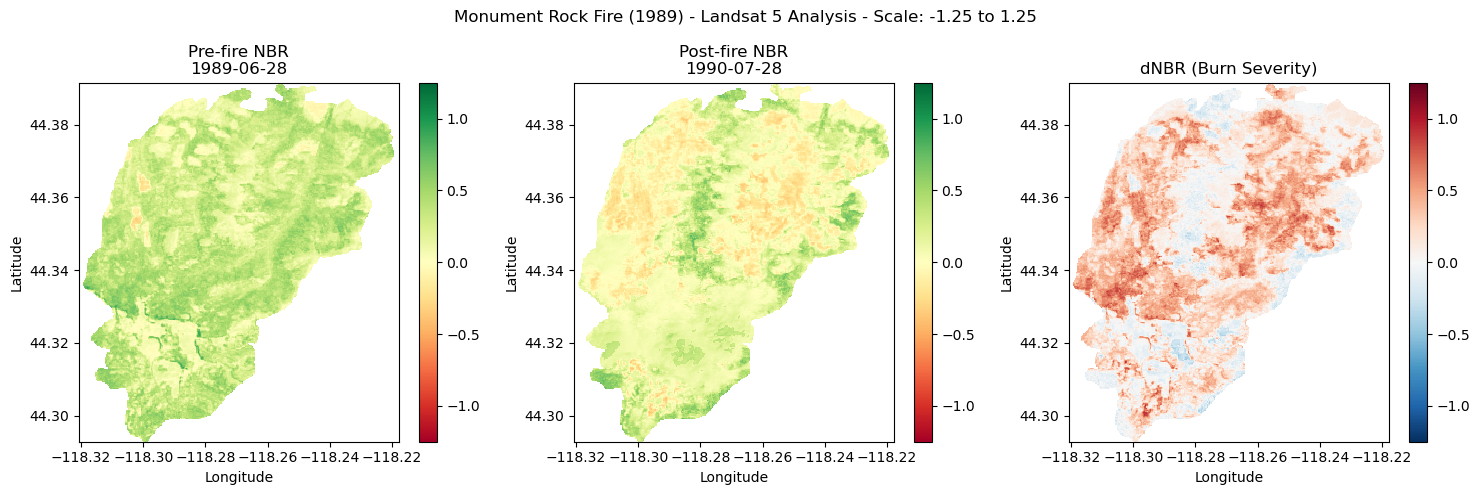

Visualization created successfully


In [15]:
if 'post_fire_results' in locals() and len(post_fire_results) > 0:
    
    print("=" * 70)
    print("LANDSAT 5 MULTI-YEAR ANALYSIS RESULTS")
    print("=" * 70)
    print(f"Fire: {incident} ({fire_id}), Year: {fire_year}")
    print(f"Fire Date: {fire_date_parsed.strftime('%Y-%m-%d')}")
    print(f"Satellite: Landsat 5 (30m resolution)")
    
    # Display scale information
    if CUSTOM_NBR_RANGE is not None and CUSTOM_DNBR_RANGE is not None:
        print(f"Custom Scales: NBR {CUSTOM_NBR_RANGE[0]} to {CUSTOM_NBR_RANGE[1]}, dNBR {CUSTOM_DNBR_RANGE[0]} to {CUSTOM_DNBR_RANGE[1]}")
    elif CUSTOM_NBR_RANGE is not None:
        print(f"Custom NBR Scale: {CUSTOM_NBR_RANGE[0]} to {CUSTOM_NBR_RANGE[1]}, dNBR: -1.25 to 1.25 (default)")
    elif CUSTOM_DNBR_RANGE is not None:
        print(f"NBR: -1.25 to 1.25 (default), Custom dNBR Scale: {CUSTOM_DNBR_RANGE[0]} to {CUSTOM_DNBR_RANGE[1]}")
    else:
        print(f"Scale: -1.25 to 1.25 (symmetric)")
    
    print(f"Pre-fire NBR Statistics:")
    print(f"Mean: {float(pre_stats.mean().values):.3f}")
    
    for year_offset, result in post_fire_results.items():
        print(f"{year_offset}-Year Post-fire Analysis:")
        print(f"Post-fire NBR - Mean: {float(result['post_stats'].mean().values):.3f}")
        print(f"dNBR - Mean: {np.mean(result['dnbr_flat']):.3f}, Range: {np.min(result['dnbr_flat']):.3f} to {np.max(result['dnbr_flat']):.3f}")
        
        severity = result['severity_results']
        total = severity['total_pixels']
        print(f"Burn Severity Classification ({total} pixels) - Key & Benson (2006) thresholds:")
        print(f"  High Severity (>0.66):      {severity['high_severity']:5d} pixels ({100*severity['high_severity']/total:5.1f}%)")
        print(f"  Moderate-High (0.44-0.66):  {severity['mod_high_severity']:5d} pixels ({100*severity['mod_high_severity']/total:5.1f}%)")
        print(f"  Moderate-Low (0.25-0.44):   {severity['mod_low_severity']:5d} pixels ({100*severity['mod_low_severity']/total:5.1f}%)")
        print(f"  Low Severity (0.1-0.25):    {severity['low_severity']:5d} pixels ({100*severity['low_severity']/total:5.1f}%)")
        print(f"  Unburned (<0.1):            {severity['unburned']:5d} pixels ({100*severity['unburned']/total:5.1f}%)")
    
    print("Analysis complete")
    
    # Create visualization
    try:
        print("Creating visualization...")
        
        # Set scale ranges
        if CUSTOM_NBR_RANGE is not None:
            nbr_vmin, nbr_vmax = CUSTOM_NBR_RANGE
        else:
            nbr_vmin, nbr_vmax = -1.25, 1.25
        
        if CUSTOM_DNBR_RANGE is not None:
            dnbr_vmin, dnbr_vmax = CUSTOM_DNBR_RANGE
        else:
            dnbr_vmin, dnbr_vmax = -1.25, 1.25
        
        # Create plots for each year
        for year_offset, result in post_fire_results.items():
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            # Reproject data for plotting
            pre_geo = pre_fire_nbr.rio.reproject('EPSG:4326')
            post_geo = result['post_fire_nbr'].rio.reproject('EPSG:4326')
            dnbr_geo = result['dnbr'].rio.reproject('EPSG:4326')
            
            # Plot pre-fire NBR
            pre_geo.plot(ax=axes[0], cmap='RdYlGn', vmin=nbr_vmin, vmax=nbr_vmax)
            axes[0].set_title(f'Pre-fire NBR\n{pre_fire_date.strftime("%Y-%m-%d")}')
            axes[0].set_xlabel('Longitude')
            axes[0].set_ylabel('Latitude')
            
            # Plot post-fire NBR
            post_geo.plot(ax=axes[1], cmap='RdYlGn', vmin=nbr_vmin, vmax=nbr_vmax)
            if year_offset == 1:
                axes[1].set_title(f'Post-fire NBR\n{result["post_fire_date"].strftime("%Y-%m-%d")}')
            else:
                axes[1].set_title(f'{year_offset}-Year Post-fire NBR\n{result["post_fire_date"].strftime("%Y-%m-%d")}')
            axes[1].set_xlabel('Longitude')
            axes[1].set_ylabel('Latitude')
            
            # Plot dNBR
            dnbr_geo.plot(ax=axes[2], cmap='RdBu_r', vmin=dnbr_vmin, vmax=dnbr_vmax)
            axes[2].set_title('dNBR (Burn Severity)')
            axes[2].set_xlabel('Longitude')
            axes[2].set_ylabel('Latitude')
            
            # Create title
            scale_info = []
            if CUSTOM_NBR_RANGE is not None:
                scale_info.append(f"NBR: {CUSTOM_NBR_RANGE[0]} to {CUSTOM_NBR_RANGE[1]}")
            if CUSTOM_DNBR_RANGE is not None:
                scale_info.append(f"dNBR: {CUSTOM_DNBR_RANGE[0]} to {CUSTOM_DNBR_RANGE[1]}")
            if not scale_info:
                scale_info.append("Scale: -1.25 to 1.25")
            
            if len(POST_FIRE_YEARS) == 1:
                plt.suptitle(f'{incident} Fire ({fire_year}) - Landsat 5 Analysis - {", ".join(scale_info)}')
            else:
                plt.suptitle(f'{incident} Fire ({fire_year}) - {year_offset}-Year Analysis - {", ".join(scale_info)}')
            
            plt.tight_layout()
            plt.show()
        
        print("Visualization created successfully")
        
    except Exception as plot_error:
        print(f"Plotting failed: {plot_error}")
        import traceback
        traceback.print_exc()

else:
    print("No post-fire results to display")


### Full dNBR Module

In [57]:
"""
Enhanced Fire Severity Analysis using Landsat 5 NBR - COMPLETE VERSION

This module analyzes wildfire burn severity using Normalized Burn Ratio (NBR) 
calculated from Landsat 5 satellite imagery with options for multi-year analysis.

Functions:
- clean_fire_year(): Converts fire year values to integers, handling various formats
- search_landsat5_imagery(): Searches for Landsat 5 images around a target date (polygon-based)
- search_with_expanding_dates(): Searches with progressively wider date ranges (max 60 days)
- calculate_nbr(): Computes NBR from Landsat 5 NIR and SWIR2 bands
- analyze_burn_severity(): Classifies burn severity from dNBR values
- create_multi_year_plots(): Creates visualization plots for multi-year analysis
- run_fire_analysis(): Main workflow to analyze a single fire with multi-year options
- run_fire_analysis_by_date(): Analyze fire using specific fire date with multi-year options

Usage:
    run_fire_analysis(target_year=1989, post_fire_years=[1, 2, 5])
    run_fire_analysis_by_date("Canyon Creek", "1989-08-04", post_fire_years=[1, 2])
"""

import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray as rxr
import pystac_client
import planetary_computer as pc
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


def clean_fire_year(year_value):
    """Convert fire year to integer, handling strings and numbers."""
    try:
        if pd.isna(year_value):
            return None
        year_str = str(year_value)
        if '-' in year_str:
            return int(year_str.split('-')[0])
        return int(float(year_str))
    except (ValueError, TypeError):
        return None


def search_landsat5_imagery(geometry, target_date, days_buffer=30):
    """Search for Landsat 5 imagery around target date using polygon geometry."""
    start_date = (target_date - timedelta(days=days_buffer)).strftime('%Y-%m-%d')
    end_date = (target_date + timedelta(days=days_buffer)).strftime('%Y-%m-%d')
    
    print(f"Searching Landsat 5 imagery from {start_date} to {end_date}")
    
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1/",
        modifier=pc.sign_inplace
    )
    
    # Use geometry directly instead of bounding box
    geometry_dict = geometry.__geo_interface__
    
    # First try with low cloud cover
    search = catalog.search(
        collections=["landsat-c2-l2"],
        intersects=geometry_dict,
        datetime=f"{start_date}/{end_date}",
        query={
            "platform": {"in": ["landsat-5"]},
            "eo:cloud_cover": {"lt": 20}  # Stricter cloud filter
        }
    )
    
    items = list(search.items())
    
    if len(items) == 0:
        print("No images found with <20% clouds, trying <50%...")
        search = catalog.search(
            collections=["landsat-c2-l2"],
            intersects=geometry_dict,
            datetime=f"{start_date}/{end_date}",
            query={
                "platform": {"in": ["landsat-5"]},
                "eo:cloud_cover": {"lt": 50}
            }
        )
        items = list(search.items())
    
    if len(items) == 0:
        print("No images found with cloud filter, trying without...")
        search = catalog.search(
            collections=["landsat-c2-l2"],
            intersects=geometry_dict,
            datetime=f"{start_date}/{end_date}",
            query={"platform": {"in": ["landsat-5"]}}
        )
        items = list(search.items())
    
    if len(items) > 0:
        items_with_info = []
        for item in items:
            cloud_cover = item.properties.get('eo:cloud_cover', 100)
            item_date = pd.to_datetime(item.properties['datetime'])
            
            if item_date.tz is not None:
                item_date = item_date.tz_localize(None)
            if hasattr(target_date, 'tz') and target_date.tz is not None:
                target_date = target_date.tz_localize(None)
            
            date_diff = abs((item_date - target_date).days)
            items_with_info.append((item, cloud_cover, date_diff, item_date.strftime('%Y-%m-%d')))
        
        items_with_info.sort(key=lambda x: (x[2], x[1]))  # Sort by date proximity, then cloud cover
        sorted_items = [item for item, cloud, date_diff, date_str in items_with_info]
        
        print(f"Found {len(sorted_items)} Landsat 5 images:")
        for i, (item, cloud, date_diff, date_str) in enumerate(items_with_info):
            print(f"  Image {i+1}: {date_str}, {cloud:.1f}% clouds, {date_diff} days from target")
        
        return sorted_items
    else:
        print("No Landsat 5 images found")
        return []


def search_with_expanding_dates(geometry, target_date):
    """Search with progressively expanding date ranges (max 60 days)."""
    buffers = [30, 60]  # Only search up to 60 days
    
    for attempt, buffer in enumerate(buffers):
        print(f"Attempt {attempt + 1}: Searching with +/-{buffer} day buffer...")
        items = search_landsat5_imagery(geometry, target_date, days_buffer=buffer)
        
        if len(items) > 0:
            return items
            
        if attempt < len(buffers) - 1:
            print("No results, expanding search window...")
    
    print("No Landsat 5 imagery found within 60 days")
    return []


def calculate_nbr(item, fire_polygon):
    """Calculate NBR from Landsat 5 data, clipped to fire boundary."""
    try:
        signed_item = pc.sign(item)
        
        print(f"Processing image from: {item.properties.get('datetime', 'Unknown')}")
        print(f"Cloud cover: {item.properties.get('eo:cloud_cover', 'Unknown')}%")
        
        # Find NIR and SWIR2 bands
        nir_band = None
        swir2_band = None
        
        for asset_name in signed_item.assets.keys():
            if asset_name in ['B04', 'nir08']:
                nir_band = asset_name
            elif asset_name in ['B07', 'swir22']:
                swir2_band = asset_name
        
        if nir_band is None or swir2_band is None:
            print(f"Could not find required bands. NIR: {nir_band}, SWIR2: {swir2_band}")
            return None
        
        print(f"Using NIR band: {nir_band}, SWIR2 band: {swir2_band}")
        
        # Load bands
        nir = rxr.open_rasterio(signed_item.assets[nir_band].href, chunks={'x': 1024, 'y': 1024})
        swir2 = rxr.open_rasterio(signed_item.assets[swir2_band].href, chunks={'x': 1024, 'y': 1024})
        
        # Convert fire polygon to raster CRS
        temp_gdf = gpd.GeoDataFrame([1], geometry=[fire_polygon], crs='EPSG:4326')
        fire_proj = temp_gdf.to_crs(nir.rio.crs).geometry.iloc[0]
        
        # Create a buffered version for initial crop (more efficient than loading full scene)
        fire_buffered = fire_proj.buffer(2000)  # 2km buffer around fire
        
        try:
            # Crop to buffered fire area first (for efficiency)
            nir_cropped = nir.rio.clip([fire_buffered], crs=nir.rio.crs, drop=True)
            swir2_cropped = swir2.rio.clip([fire_buffered], crs=swir2.rio.crs, drop=True)
            print(f"Cropped to fire area: NIR {nir_cropped.shape}, SWIR2 {swir2_cropped.shape}")
        except:
            print("Polygon cropping failed, using original extent")
            nir_cropped = nir
            swir2_cropped = swir2
        
        # Apply Landsat Collection 2 scaling
        nir_scaled = nir_cropped * 0.0000275 - 0.2
        swir2_scaled = swir2_cropped * 0.0000275 - 0.2
        
        # Ensure same resolution
        if nir_scaled.shape != swir2_scaled.shape:
            swir2_scaled = swir2_scaled.rio.reproject_match(nir_scaled)
        
        # Calculate NBR
        nbr = (nir_scaled - swir2_scaled) / (nir_scaled + swir2_scaled)
        nbr = nbr.where((nir_scaled + swir2_scaled) != 0)
        
        # Final clip to exact fire boundary
        nbr_fire_only = nbr.rio.clip([fire_proj], crs=nbr.rio.crs, drop=True, all_touched=True)
        
        # Check results
        valid_pixels = (~np.isnan(nbr_fire_only.values)).sum()
        total_pixels = nbr_fire_only.size
        
        print(f"Valid pixels: {valid_pixels}/{total_pixels} ({100*valid_pixels/total_pixels:.1f}%)")
        
        if valid_pixels == 0:
            print("No valid data within fire boundary")
            return None
        
        print("NBR calculated successfully")
        return nbr_fire_only
        
    except Exception as e:
        print(f"Error calculating NBR: {e}")
        return None


def analyze_burn_severity(dnbr_values):
    """Classify burn severity from dNBR values."""
    high_severity = np.sum(dnbr_values > 0.66)
    mod_high_severity = np.sum((dnbr_values >= 0.44) & (dnbr_values <= 0.66))
    mod_low_severity = np.sum((dnbr_values >= 0.25) & (dnbr_values < 0.44))
    low_severity = np.sum((dnbr_values >= 0.1) & (dnbr_values < 0.25))
    unburned = np.sum(dnbr_values < 0.1)
    total_pixels = len(dnbr_values)
    
    return {
        'high_severity': high_severity,
        'mod_high_severity': mod_high_severity,
        'mod_low_severity': mod_low_severity,
        'low_severity': low_severity,
        'unburned': unburned,
        'total_pixels': total_pixels
    }


def create_multi_year_plots(pre_fire_nbr, post_fire_results, incident, fire_year, 
                          pre_fire_date, custom_nbr_range=None, custom_dnbr_range=None):
    """Create visualization plots for multi-year analysis."""
    
    # Set scale ranges based on parameters
    if custom_nbr_range is not None:
        nbr_vmin, nbr_vmax = custom_nbr_range
        print(f"Using custom NBR range: {nbr_vmin} to {nbr_vmax}")
    else:
        nbr_vmin, nbr_vmax = -1.25, 1.25
    
    if custom_dnbr_range is not None:
        dnbr_vmin, dnbr_vmax = custom_dnbr_range
        print(f"Using custom dNBR range: {dnbr_vmin} to {dnbr_vmax}")
    else:
        dnbr_vmin, dnbr_vmax = -1.25, 1.25
    
    # For multi-year analysis, create separate figures for each year
    if len(post_fire_results) > 1:
        # Create multiple figures, one for each post-fire year
        for year_offset, result in post_fire_results.items():
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            # Reproject data for plotting
            pre_geo = pre_fire_nbr.rio.reproject('EPSG:4326')
            post_geo = result['post_fire_nbr'].rio.reproject('EPSG:4326')
            dnbr_geo = result['dnbr'].rio.reproject('EPSG:4326')
            
            # Plot pre-fire NBR
            pre_geo.plot(ax=axes[0], cmap='RdYlGn', vmin=nbr_vmin, vmax=nbr_vmax)
            axes[0].set_title(f'Pre-fire NBR\n{pre_fire_date.strftime("%Y-%m-%d")}')
            axes[0].set_xlabel('Longitude')
            axes[0].set_ylabel('Latitude')
            
            # Plot post-fire NBR
            post_geo.plot(ax=axes[1], cmap='RdYlGn', vmin=nbr_vmin, vmax=nbr_vmax)
            axes[1].set_title(f'{year_offset}-Year Post-fire NBR\n{result["post_fire_date"].strftime("%Y-%m-%d")}')
            axes[1].set_xlabel('Longitude')
            axes[1].set_ylabel('Latitude')
            
            # Plot dNBR
            dnbr_geo.plot(ax=axes[2], cmap='RdBu_r', vmin=dnbr_vmin, vmax=dnbr_vmax)
            axes[2].set_title(f'{year_offset}-Year dNBR\n(Burn Severity)')
            axes[2].set_xlabel('Longitude')
            axes[2].set_ylabel('Latitude')
            
            # Create scale info text for title
            scale_info = []
            if custom_nbr_range is not None:
                scale_info.append(f"NBR: {custom_nbr_range[0]} to {custom_nbr_range[1]}")
            if custom_dnbr_range is not None:
                scale_info.append(f"dNBR: {custom_dnbr_range[0]} to {custom_dnbr_range[1]}")
            if not scale_info:
                scale_info.append("Scale: -1.25 to 1.25")
            
            plt.suptitle(f'{incident} Fire ({fire_year}) - {year_offset}-Year Analysis - {", ".join(scale_info)}')
            plt.tight_layout()
            plt.show()
    
    else:
        # Single year analysis - original 3-plot layout
        year_offset = list(post_fire_results.keys())[0]
        result = post_fire_results[year_offset]
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Reproject data for plotting
        pre_geo = pre_fire_nbr.rio.reproject('EPSG:4326')
        post_geo = result['post_fire_nbr'].rio.reproject('EPSG:4326')
        dnbr_geo = result['dnbr'].rio.reproject('EPSG:4326')
        
        # Plot pre-fire NBR
        pre_geo.plot(ax=axes[0], cmap='RdYlGn', vmin=nbr_vmin, vmax=nbr_vmax)
        axes[0].set_title(f'Pre-fire NBR\n{pre_fire_date.strftime("%Y-%m-%d")}')
        axes[0].set_xlabel('Longitude')
        axes[0].set_ylabel('Latitude')
        
        # Plot post-fire NBR
        post_geo.plot(ax=axes[1], cmap='RdYlGn', vmin=nbr_vmin, vmax=nbr_vmax)
        if year_offset == 1:
            axes[1].set_title(f'Post-fire NBR\n{result["post_fire_date"].strftime("%Y-%m-%d")}')
        else:
            axes[1].set_title(f'{year_offset}-Year Post-fire NBR\n{result["post_fire_date"].strftime("%Y-%m-%d")}')
        axes[1].set_xlabel('Longitude')
        axes[1].set_ylabel('Latitude')
        
        # Plot dNBR
        dnbr_geo.plot(ax=axes[2], cmap='RdBu_r', vmin=dnbr_vmin, vmax=dnbr_vmax)
        axes[2].set_title('dNBR (Burn Severity)')
        axes[2].set_xlabel('Longitude')
        axes[2].set_ylabel('Latitude')
        
        # Create scale info text for title
        scale_info = []
        if custom_nbr_range is not None:
            scale_info.append(f"NBR: {custom_nbr_range[0]} to {custom_nbr_range[1]}")
        if custom_dnbr_range is not None:
            scale_info.append(f"dNBR: {custom_dnbr_range[0]} to {custom_dnbr_range[1]}")
        if not scale_info:
            scale_info.append("Scale: -1.25 to 1.25")
        
        plt.suptitle(f'{incident} Fire ({fire_year}) - Landsat 5 Analysis - {", ".join(scale_info)}')
        plt.tight_layout()
        plt.show()


def run_fire_analysis_by_date(fire_name, fire_date, geojson_path="../downloaded_data/mnf_fires_all.geojson", 
                              pre_fire_days=30, post_fire_years=[1], 
                              custom_nbr_range=None, custom_dnbr_range=None, return_data=False):
    """
    Analyze fire burn severity using actual fire date with multi-year options.
    
    Parameters:
    - fire_name: Name of the fire to search for
    - fire_date: Date when fire was contained/detected (e.g., "1989-08-04")
    - pre_fire_days: Days before fire_date to search for pre-fire imagery (default 30)
    - post_fire_years: List of years after fire to analyze (default [1])
    - custom_nbr_range: Tuple (min, max) for custom NBR scale (default: -1.25 to 1.25)
    - custom_dnbr_range: Tuple (min, max) for custom dNBR scale (default: -1.25 to 1.25)
    - return_data: Return full data dictionary (default False)
    
    Examples:
    - Custom scales: custom_nbr_range=(-0.8, 1.2), custom_dnbr_range=(-0.5, 1.5)
    """
    print(f"Loading fire data to find '{fire_name}'...")
    fires = gpd.read_file(geojson_path)
    
    # Clean fire year data
    fires['FIRE_YEAR_CLEAN'] = fires['FIRE_YEAR'].apply(clean_fire_year)
    fires_clean = fires.dropna(subset=['FIRE_YEAR_CLEAN'])
    fires_clean['FIRE_YEAR_CLEAN'] = fires_clean['FIRE_YEAR_CLEAN'].astype(int)
    fires_wgs84 = fires_clean.to_crs('EPSG:4326')
    
    # Search for fire by name
    fire_matches = fires_wgs84[
        fires_wgs84['INCIDENT'].str.contains(fire_name, case=False, na=False)
    ]
    
    if len(fire_matches) == 0:
        print(f"No fires found matching '{fire_name}'")
        print("Available fire names (sample):")
        sample_names = fires_wgs84['INCIDENT'].dropna().head(10).tolist()
        for name in sample_names:
            print(f"  - {name}")
        return None
    
    if len(fire_matches) > 1:
        print(f"Found {len(fire_matches)} fires matching '{fire_name}':")
        for i, (idx, fire) in enumerate(fire_matches.iterrows()):
            year = int(fire['FIRE_YEAR_CLEAN'])
            fire_id = fire.get('UNQE_FIRE_', 'No ID')
            area = fire.geometry.area * 111 * 111 * 100  # rough hectares
            print(f"  {i}: {fire['INCIDENT']} ({year}) - {area:.1f} ha - {fire_id}")
        
        # Use the first match
        selected_fire = fire_matches.iloc[0]
        print(f"Using: {selected_fire['INCIDENT']} ({int(selected_fire['FIRE_YEAR_CLEAN'])})")
    else:
        selected_fire = fire_matches.iloc[0]
        print(f"Found: {selected_fire['INCIDENT']} ({int(selected_fire['FIRE_YEAR_CLEAN'])})")
    
    # Extract fire info
    fire_geom = selected_fire.geometry
    fire_id = selected_fire.get("UNQE_FIRE_", "unknown")
    incident = selected_fire.get("INCIDENT", "unknown")
    fire_year = int(selected_fire["FIRE_YEAR_CLEAN"])
    
    print(f"\nSelected Fire: {incident} ({fire_id})")
    print(f"Fire Year: {fire_year}")
    print(f"Fire Area: {fire_geom.area:.8f} square degrees")
    
    # Parse fire date and calculate analysis dates
    fire_date_parsed = pd.to_datetime(fire_date)
    pre_fire_date = fire_date_parsed - timedelta(days=pre_fire_days)
    
    print(f"\nAnalysis Timeline:")
    print(f"Fire date (contained): {fire_date_parsed.strftime('%Y-%m-%d')}")
    print(f"Pre-fire target: {pre_fire_date.strftime('%Y-%m-%d')} ({pre_fire_days} days before)")
    print(f"Post-fire analysis years: {post_fire_years}")
    
    # Search for pre-fire imagery
    print(f"\n1. Searching for pre-fire imagery...")
    pre_fire_items = search_with_expanding_dates(fire_geom, pre_fire_date)
    
    if len(pre_fire_items) == 0:
        print("No pre-fire imagery found")
        return None
    
    # Calculate pre-fire NBR
    print(f"\n2. Calculating pre-fire NBR...")
    pre_fire_nbr = calculate_nbr(pre_fire_items[0], fire_geom)
    
    if pre_fire_nbr is None:
        print("Failed to calculate pre-fire NBR")
        return None
    
    pre_stats = pre_fire_nbr.compute()
    print(f"Pre-fire NBR: Mean {float(pre_stats.mean().values):.3f}")
    
    # Process each post-fire year
    post_fire_results = {}
    
    for year_offset in post_fire_years:
        print(f"\n3. Processing {year_offset}-year post-fire analysis...")
        post_fire_date = fire_date_parsed + timedelta(days=365 * year_offset)
        print(f"Post-fire target: {post_fire_date.strftime('%Y-%m-%d')} ({year_offset} year(s) after)")
        
        # Search for post-fire imagery
        print(f"Searching for {year_offset}-year post-fire imagery...")
        post_fire_items = search_with_expanding_dates(fire_geom, post_fire_date)
        
        if len(post_fire_items) == 0:
            print(f"No {year_offset}-year post-fire imagery found")
            continue
        
        # Calculate post-fire NBR
        print(f"Calculating {year_offset}-year post-fire NBR...")
        post_fire_nbr = calculate_nbr(post_fire_items[0], fire_geom)
        
        if post_fire_nbr is None:
            print(f"Failed to calculate {year_offset}-year post-fire NBR")
            continue
        
        post_stats = post_fire_nbr.compute()
        print(f"{year_offset}-year post-fire NBR: Mean {float(post_stats.mean().values):.3f}")
        
        # Calculate dNBR
        print(f"Calculating {year_offset}-year dNBR...")
        
        if pre_fire_nbr.rio.crs != post_fire_nbr.rio.crs:
            post_fire_nbr = post_fire_nbr.rio.reproject_match(pre_fire_nbr)
        
        dnbr = pre_fire_nbr - post_fire_nbr
        dnbr_computed = dnbr.compute()
        dnbr_flat = dnbr_computed.values.flatten()
        dnbr_flat = dnbr_flat[~np.isnan(dnbr_flat)]
        
        if len(dnbr_flat) == 0:
            print(f"No valid {year_offset}-year dNBR values calculated")
            continue
        
        # Analyze burn severity
        severity_results = analyze_burn_severity(dnbr_flat)
        
        # Store results
        post_fire_results[year_offset] = {
            'post_fire_date': post_fire_date,
            'post_fire_nbr': post_fire_nbr,
            'post_stats': post_stats,
            'dnbr': dnbr,
            'dnbr_flat': dnbr_flat,
            'severity_results': severity_results
        }
    
    if len(post_fire_results) == 0:
        print("No post-fire analyses completed successfully")
        return None
    
    # Display results
    print(f"\n" + "="*70)
    print("LANDSAT 5 MULTI-YEAR ANALYSIS RESULTS")
    print("="*70)
    print(f"Fire: {incident} ({fire_id}), Year: {fire_year}")
    print(f"Fire Date: {fire_date_parsed.strftime('%Y-%m-%d')}")
    print(f"Satellite: Landsat 5 (30m resolution)")
    
    # Display scale information
    if custom_nbr_range is not None and custom_dnbr_range is not None:
        print(f"Custom Scales: NBR {custom_nbr_range[0]} to {custom_nbr_range[1]}, dNBR {custom_dnbr_range[0]} to {custom_dnbr_range[1]}")
    elif custom_nbr_range is not None:
        print(f"Custom NBR Scale: {custom_nbr_range[0]} to {custom_nbr_range[1]}, dNBR: -1.25 to 1.25 (default)")
    elif custom_dnbr_range is not None:
        print(f"NBR: -1.25 to 1.25 (default), Custom dNBR Scale: {custom_dnbr_range[0]} to {custom_dnbr_range[1]}")
    else:
        print(f"Scale: -1.25 to 1.25 (symmetric)")
    
    print(f"\nPre-fire NBR Statistics:")
    print(f"Mean: {float(pre_stats.mean().values):.3f}")
    
    for year_offset, result in post_fire_results.items():
        print(f"\n{year_offset}-Year Post-fire Analysis:")
        print(f"Post-fire NBR - Mean: {float(result['post_stats'].mean().values):.3f}")
        print(f"dNBR - Mean: {np.mean(result['dnbr_flat']):.3f}, Range: {np.min(result['dnbr_flat']):.3f} to {np.max(result['dnbr_flat']):.3f}")
        
        severity = result['severity_results']
        total = severity['total_pixels']
        print(f"Burn Severity Classification ({total} pixels) - Key & Benson (2006) thresholds:")
        print(f"  High Severity (>0.66):      {severity['high_severity']:5d} pixels ({100*severity['high_severity']/total:5.1f}%)")
        print(f"  Moderate-High (0.44-0.66):  {severity['mod_high_severity']:5d} pixels ({100*severity['mod_high_severity']/total:5.1f}%)")
        print(f"  Moderate-Low (0.25-0.44):   {severity['mod_low_severity']:5d} pixels ({100*severity['mod_low_severity']/total:5.1f}%)")
        print(f"  Low Severity (0.1-0.25):    {severity['low_severity']:5d} pixels ({100*severity['low_severity']/total:5.1f}%)")
        print(f"  Unburned (<0.1):            {severity['unburned']:5d} pixels ({100*severity['unburned']/total:5.1f}%)")
    
    print(f"\n✓ Analysis complete!")
    
    # Create visualization
    try:
        create_multi_year_plots(pre_fire_nbr, post_fire_results, incident, fire_year, 
                              pre_fire_date, custom_nbr_range, custom_dnbr_range)
    except Exception as plot_error:
        print(f"Plotting failed: {plot_error}")
    
    # Return data only if requested
    if return_data:
        return {
            'fire_info': {
                'name': incident,
                'id': fire_id,
                'year': fire_year,
                'fire_date': fire_date_parsed,
                'geometry': fire_geom
            },
            'analysis_dates': {
                'pre_fire': pre_fire_date,
            },
            'pre_fire_nbr': pre_fire_nbr,
            'post_fire_results': post_fire_results,
            'custom_nbr_range': custom_nbr_range,
            'custom_dnbr_range': custom_dnbr_range
        }
    
    # Explicitly return None to prevent any output in Jupyter
    return None


def run_fire_analysis(target_year=1989, geojson_path="../downloaded_data/mnf_fires_all.geojson", 
                     post_fire_years=[1], 
                     custom_nbr_range=None, custom_dnbr_range=None, return_data=False):
    """
    Main workflow to analyze fire burn severity for a specific year with multi-year options.
    
    Parameters:
    - target_year: Year of fire to analyze
    - geojson_path: Path to fire data
    - post_fire_years: List of years after fire to analyze (default [1])
    - custom_nbr_range: Tuple (min, max) for custom NBR scale (default: -1.25 to 1.25)
    - custom_dnbr_range: Tuple (min, max) for custom dNBR scale (default: -1.25 to 1.25)
    - return_data: Return full data dictionary (default False)
    """
    print(f"Loading fire data for {target_year}...")
    fires = gpd.read_file(geojson_path)
    
    # Clean fire year data
    fires['FIRE_YEAR_CLEAN'] = fires['FIRE_YEAR'].apply(clean_fire_year)
    fires_clean = fires.dropna(subset=['FIRE_YEAR_CLEAN'])
    fires_clean['FIRE_YEAR_CLEAN'] = fires_clean['FIRE_YEAR_CLEAN'].astype(int)
    
    print(f"Available years: {sorted(fires_clean['FIRE_YEAR_CLEAN'].unique())}")
    
    # Filter for target year
    target_fires = fires_clean[fires_clean['FIRE_YEAR_CLEAN'] == target_year].copy()
    print(f"Found {len(target_fires)} fires from {target_year}")
    
    if len(target_fires) == 0:
        print(f"No fires found for {target_year}. Trying nearby years...")
        for test_year in [target_year-1, target_year+1, target_year-2, target_year+2]:
            test_fires = fires_clean[fires_clean['FIRE_YEAR_CLEAN'] == test_year]
            if len(test_fires) > 0:
                print(f"Using {test_year} fires for testing ({len(test_fires)} fires)")
                target_fires = test_fires.copy()
                target_year = test_year
                break
    
    if len(target_fires) == 0:
        print(f"No fires found near year {target_year}")
        return None
    
    # Select first fire and convert to WGS84
    target_fires_wgs84 = target_fires.to_crs('EPSG:4326')
    test_fire = target_fires_wgs84.iloc[0]
    fire_geom = test_fire.geometry
    fire_id = test_fire.get("UNQE_FIRE_", "unknown")
    incident = test_fire.get("INCIDENT", "unknown")
    fire_year = int(test_fire["FIRE_YEAR_CLEAN"])
    
    print(f"\nSelected Fire: {incident} ({fire_id})")
    print(f"Fire Year: {fire_year}")
    print(f"Fire Area: {fire_geom.area:.8f} square degrees")
    
    # Define analysis dates
    pre_fire_date = pd.to_datetime(f"{fire_year}-04-15")
    
    print(f"\nAnalysis Timeline:")
    print(f"Pre-fire (baseline): {pre_fire_date.strftime('%Y-%m-%d')}")
    print(f"Post-fire analysis years: {post_fire_years}")
    
    # Search for pre-fire imagery
    print(f"\n1. Searching for pre-fire imagery...")
    pre_fire_items = search_with_expanding_dates(fire_geom, pre_fire_date)
    
    if len(pre_fire_items) == 0:
        print("No pre-fire imagery found")
        return None
    
    # Calculate pre-fire NBR
    print(f"\n2. Calculating pre-fire NBR...")
    pre_fire_nbr = calculate_nbr(pre_fire_items[0], fire_geom)
    
    if pre_fire_nbr is None:
        print("Failed to calculate pre-fire NBR")
        return None
    
    pre_stats = pre_fire_nbr.compute()
    print(f"Pre-fire NBR: Mean {float(pre_stats.mean().values):.3f}")
    
    # Process each post-fire year
    post_fire_results = {}
    
    for year_offset in post_fire_years:
        print(f"\n3. Processing {year_offset}-year post-fire analysis...")
        post_fire_date = pd.to_datetime(f"{fire_year + year_offset}-07-01")
        print(f"Post-fire target: {post_fire_date.strftime('%Y-%m-%d')} ({year_offset} year(s) after)")
        
        # Search for post-fire imagery
        print(f"Searching for {year_offset}-year post-fire imagery...")
        post_fire_items = search_with_expanding_dates(fire_geom, post_fire_date)
        
        if len(post_fire_items) == 0:
            print(f"No {year_offset}-year post-fire imagery found")
            continue
        
        # Calculate post-fire NBR
        print(f"Calculating {year_offset}-year post-fire NBR...")
        post_fire_nbr = calculate_nbr(post_fire_items[0], fire_geom)
        
        if post_fire_nbr is None:
            print(f"Failed to calculate {year_offset}-year post-fire NBR")
            continue
        
        post_stats = post_fire_nbr.compute()
        print(f"{year_offset}-year post-fire NBR: Mean {float(post_stats.mean().values):.3f}")
        
        # Calculate dNBR
        print(f"Calculating {year_offset}-year dNBR...")
        
        if pre_fire_nbr.rio.crs != post_fire_nbr.rio.crs:
            post_fire_nbr = post_fire_nbr.rio.reproject_match(pre_fire_nbr)
        
        dnbr = pre_fire_nbr - post_fire_nbr
        dnbr_computed = dnbr.compute()
        dnbr_flat = dnbr_computed.values.flatten()
        dnbr_flat = dnbr_flat[~np.isnan(dnbr_flat)]
        
        if len(dnbr_flat) == 0:
            print(f"No valid {year_offset}-year dNBR values calculated")
            continue
        
        # Analyze burn severity
        severity_results = analyze_burn_severity(dnbr_flat)
        
        # Store results
        post_fire_results[year_offset] = {
            'post_fire_date': post_fire_date,
            'post_fire_nbr': post_fire_nbr,
            'post_stats': post_stats,
            'dnbr': dnbr,
            'dnbr_flat': dnbr_flat,
            'severity_results': severity_results
        }
    
    if len(post_fire_results) == 0:
        print("No post-fire analyses completed successfully")
        return None
    
    # Display results
    print(f"\n" + "="*70)
    print("LANDSAT 5 MULTI-YEAR ANALYSIS RESULTS")
    print("="*70)
    print(f"Fire: {incident} ({fire_id}), Year: {fire_year}")
    print(f"Satellite: Landsat 5 (30m resolution)")
    
    # Display scale information
    if custom_nbr_range is not None and custom_dnbr_range is not None:
        print(f"Custom Scales: NBR {custom_nbr_range[0]} to {custom_nbr_range[1]}, dNBR {custom_dnbr_range[0]} to {custom_dnbr_range[1]}")
    elif custom_nbr_range is not None:
        print(f"Custom NBR Scale: {custom_nbr_range[0]} to {custom_nbr_range[1]}, dNBR: -1.25 to 1.25 (default)")
    elif custom_dnbr_range is not None:
        print(f"NBR: -1.25 to 1.25 (default), Custom dNBR Scale: {custom_dnbr_range[0]} to {custom_dnbr_range[1]}")
    else:
        print(f"Scale: -1.25 to 1.25 (symmetric)")
    
    print(f"\nPre-fire NBR Statistics:")
    print(f"Mean: {float(pre_stats.mean().values):.3f}")
    
    for year_offset, result in post_fire_results.items():
        print(f"\n{year_offset}-Year Post-fire Analysis:")
        print(f"Post-fire NBR - Mean: {float(result['post_stats'].mean().values):.3f}")
        print(f"dNBR - Mean: {np.mean(result['dnbr_flat']):.3f}, Range: {np.min(result['dnbr_flat']):.3f} to {np.max(result['dnbr_flat']):.3f}")
        
        severity = result['severity_results']
        total = severity['total_pixels']
        print(f"Burn Severity Classification ({total} pixels) - Key & Benson (2006) thresholds:")
        print(f"  High Severity (>0.66):      {severity['high_severity']:5d} pixels ({100*severity['high_severity']/total:5.1f}%)")
        print(f"  Moderate-High (0.44-0.66):  {severity['mod_high_severity']:5d} pixels ({100*severity['mod_high_severity']/total:5.1f}%)")
        print(f"  Moderate-Low (0.25-0.44):   {severity['mod_low_severity']:5d} pixels ({100*severity['mod_low_severity']/total:5.1f}%)")
        print(f"  Low Severity (0.1-0.25):    {severity['low_severity']:5d} pixels ({100*severity['low_severity']/total:5.1f}%)")
        print(f"  Unburned (<0.1):            {severity['unburned']:5d} pixels ({100*severity['unburned']/total:5.1f}%)")
    
    print(f"\n✓ Analysis complete for {fire_year} fire!")
    
    # Create visualization
    try:
        create_multi_year_plots(pre_fire_nbr, post_fire_results, incident, fire_year, 
                              pre_fire_date, custom_nbr_range, custom_dnbr_range)
    except Exception as plot_error:
        print(f"Plotting failed: {plot_error}")
    
    # Return data only if requested
    if return_data:
        return {
            'fire_info': {
                'name': incident,
                'id': fire_id,
                'year': fire_year,
                'geometry': fire_geom
            },
            'analysis_dates': {
                'pre_fire': pre_fire_date,
            },
            'pre_fire_nbr': pre_fire_nbr,
            'post_fire_results': post_fire_results,
            'custom_nbr_range': custom_nbr_range,
            'custom_dnbr_range': custom_dnbr_range
        }
    
    # Explicitly return None to prevent any output in Jupyter
    return None


if __name__ == "__main__":
    print("Enhanced Fire Severity Analysis - COMPLETE MODULE")
    print("="*60)
    print("Functions:")
    print("run_fire_analysis_by_date() - Analyze using specific fire date")
    print("run_fire_analysis() - Analyze using target year")
    print("NOTE: Add ';' at end of line in Jupyter to suppress dictionary output")
    print()
    print("Quick Examples:")
    print("run_fire_analysis_by_date('Canyon Creek', '1989-08-04')  # Clean execution")
    print("data = run_fire_analysis_by_date('Canyon Creek', '1989-08-04', return_data=True)  # Get data")
    print("run_fire_analysis_by_date('Canyon Creek', '1989-08-04', post_fire_years=[1,2,5]);  # Suppress output with ;")
    print()
    print("Key Parameters:")
    print("post_fire_years=[1,2,5] - Years to analyze after fire")
    print("custom_nbr_range=(-1,1) - Custom NBR scale (default: -1.25 to 1.25)")
    print("custom_dnbr_range=(0,2) - Custom dNBR scale (default: -1.25 to 1.25)")
    print("return_data=True - Return data (default: just show plots)")
    print()
    print("dNBR Thresholds: High>0.66, Mod-High 0.44-0.66, Mod-Low 0.25-0.44, Low 0.1-0.25")

Enhanced Fire Severity Analysis - COMPLETE MODULE
Functions:
run_fire_analysis_by_date() - Analyze using specific fire date
run_fire_analysis() - Analyze using target year
NOTE: Add ';' at end of line in Jupyter to suppress dictionary output

Quick Examples:
run_fire_analysis_by_date('Canyon Creek', '1989-08-04')  # Clean execution
data = run_fire_analysis_by_date('Canyon Creek', '1989-08-04', return_data=True)  # Get data
run_fire_analysis_by_date('Canyon Creek', '1989-08-04', post_fire_years=[1,2,5]);  # Suppress output with ;

Key Parameters:
post_fire_years=[1,2,5] - Years to analyze after fire
custom_nbr_range=(-1,1) - Custom NBR scale (default: -1.25 to 1.25)
custom_dnbr_range=(0,2) - Custom dNBR scale (default: -1.25 to 1.25)
return_data=True - Return data (default: just show plots)

dNBR Thresholds: High>0.66, Mod-High 0.44-0.66, Mod-Low 0.25-0.44, Low 0.1-0.25


Loading fire data to find 'Monument Rock'...
Found: Monument Rock (1989)

Selected Fire: Monument Rock (1989-ORWWF-000377)
Fire Year: 1989
Fire Area: 0.00575968 square degrees

Analysis Timeline:
Fire date (contained): 1989-07-28
Pre-fire target: 1989-07-14 (14 days before)
Post-fire analysis years: [1]

1. Searching for pre-fire imagery...
Attempt 1: Searching with +/-30 day buffer...
Searching Landsat 5 imagery from 1989-06-14 to 1989-08-13
Found 2 Landsat 5 images:
  Image 1: 1989-07-28, 0.0% clouds, 14 days from target
  Image 2: 1989-08-13, 0.0% clouds, 30 days from target

2. Calculating pre-fire NBR...
Processing image from: 1989-07-28T18:05:01.513094Z
Cloud cover: 0.0%
Using NIR band: nir08, SWIR2 band: swir22
Cropped to fire area: NIR (1, 494, 400), SWIR2 (1, 494, 400)
Valid pixels: 57452/97016 (59.2%)
NBR calculated successfully
Pre-fire NBR: Mean 0.318

3. Processing 1-year post-fire analysis...
Post-fire target: 1990-07-28 (1 year(s) after)
Searching for 1-year post-fire im

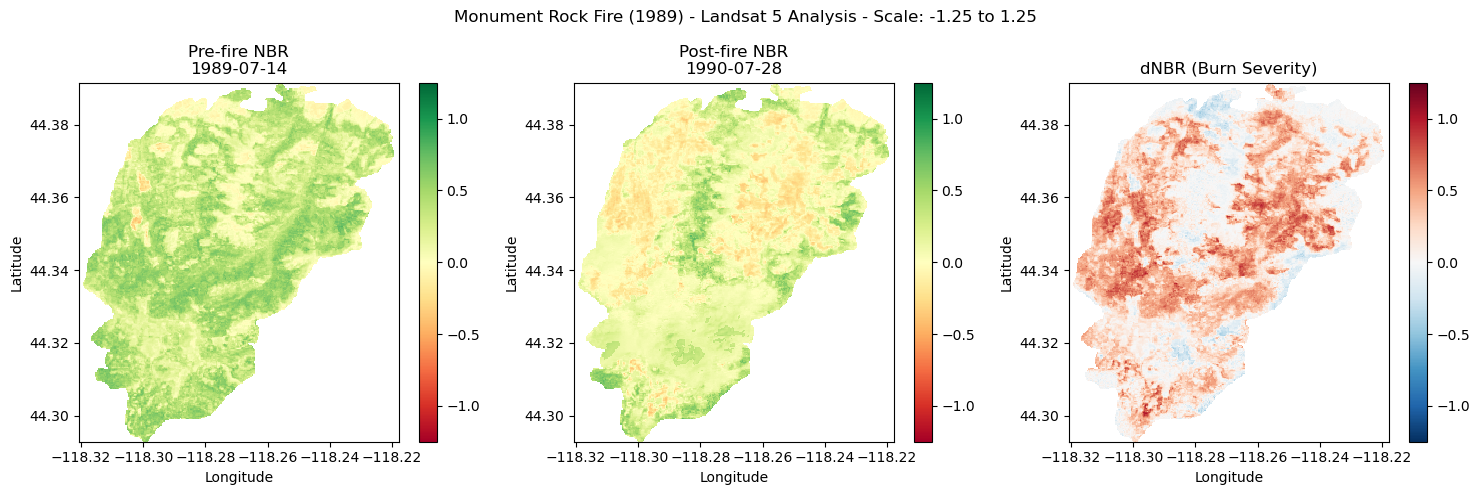

In [58]:
run_fire_analysis_by_date('Monument Rock', 
                          '1989-07-28', 
                            pre_fire_days=14);